# Ex8.8 Trajectory Sampling Exercise

## 0. Problem Definitions

* undiscounted episodic tasks
* 2 actions from each state, each resulting in one of $b$ states, all equally likely
* different random selection of $b$ states for each state-action pair
* for each transition theres a $0.1$ chance of entering a terminal state
* expected reward for each transition sampled from $\mathcal{N}(0,1)$

## 1. Environment

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [2]:
class Environment:
    def __init__(self, state_amount, actions, branching_factor):
        self.states   = state_amount
        self.actions  = actions
        self.branches = branching_factor
        
        self.build_transition_graph()
        
    def build_transition_graph(self):
        '''build neighbors for each state randomly'''
        self.trans = np.random.randint(self.states, size=(self.states, self.actions, self.branches))
    
    def get_start(self):
        '''Return the starting position (arbitrary but constant)'''
        return 0
    
    def get_reward(self):
        '''Returns reward as defined'''
        return np.random.normal()
    
    def get_random_branch(self):
        '''Choose a random branch'''
        return np.random.randint(self.branches)

    def is_terminal(self):
        '''Call to determine if move is terminal'''
        return np.random.rand() < 0.1

## 2. One Step Tabular Planning

In [3]:
class TabularPlanning:
    
    def __init__(self, environment, alpha, gamma, epsilon, exp_updates):
        self.env     = environment
        self.alpha   = alpha
        self.gamma   = gamma
        self.epsilon = epsilon
        
        self.exp_updates = exp_updates
        
    def reset(self):
        '''Reset Seed, State-Action Value Function and History of Start-State Values'''
        np.random.seed(0)
        self.Q    = np.zeros((self.env.states, self.env.actions))
        self.hist = np.zeros(self.exp_updates)
        
    def step(self, S, A):
        '''Move according to Environment - get new State and Reward'''
        B  = self.env.get_random_branch()
        Sn = self.env.trans[S, A, B]
        R  = self.env.get_reward()
        return Sn, R
    
    def update_q(self, S, A, R, Sn):
        '''Update State-Action Value Function with given transition'''
        Am   = np.argmax(self.Q[Sn])
        idx  = (S,  A)
        idxn = (Sn, Am)
        self.Q[idx] += self.alpha * (R * self.gamma * self.Q[idxn] - self.Q[idx])
        
    def epsilon_greedy(self, S):
        '''Epsilon-Greedy Policy for selecting an Action'''
        if np.random.rand() > self.epsilon:
            return np.argmax(self.Q[S])
        else:
            return np.random.randint(self.env.actions)
        
    def train_uniform(self):
        '''Train uniformly by iterating over all states and their actions
        and then updating them inplace'''
        updates = 0
        
        while True:
            for S in range(self.env.states):
                for A in range(self.env.actions):
                    if updates < self.exp_updates:
                        Sn, R = self.step(S, A)

                        self.update_q(S, A, R, Sn)
                        self.hist[updates] = self.get_start_state_value()
                    else:
                        return self.hist
                    
                    updates += 1
        
    def train_trajectory_sample(self):
        '''Train according to a Epsilon-Greedy Policy'''
        updates = 0
        
        while True:
            S = self.env.get_start()

            while not self.is_done():
                if updates < self.exp_updates:
                    A = self.epsilon_greedy(S)
                    Sn, R = self.step(S, A)

                    self.update_q(S, A, R, Sn)
                    self.hist[updates] = self.get_start_state_value()
                else:
                    return self.hist
                
                updates += 1
                
                S = Sn
                
    def get_start_state_value(self):
        '''Average over all transitions into the Starting State'''
        start = self.env.get_start()
        value = 0
        
        for state in range(self.env.states):
            for action in range(self.env.actions):
                for branch in range(self.env.branches):
                    if self.env.trans[state, action, branch] == start:
                        # '* 0.5' to average out the values 
                        # '1 / branches' is the probability of choosing the exact transition
                        # 'Q[S, A]' is the expected value
                        value += 0.5 * (1 / self.env.branches) * self.Q[state, action]
        
        return value
    
    def is_done(self):
        '''True if the environment decides it's over'''
        return self.env.is_terminal()

## 3. Training

In [4]:
# World Parameters
state_amount      = 1000
actions           = 2
branching_factor  = 1
branching_factor2 = 3

# Agent Parameters
alpha             = 0.1
gamma             = 1
epsilon           = 0.1
exp_updates       = 20000
world             = Environment(state_amount, actions, branching_factor)
world2            = Environment(state_amount, actions, branching_factor2)

# Agent Definitions
agent_uniform     = TabularPlanning(world, alpha, gamma, epsilon, exp_updates)
agent_traject     = TabularPlanning(world, alpha, gamma, epsilon, exp_updates)
agent_uniform2    = TabularPlanning(world2, alpha, gamma, epsilon, exp_updates)
agent_traject2    = TabularPlanning(world2, alpha, gamma, epsilon, exp_updates)

### 3.1 Branching Factor 1

In [5]:
agent_uniform.reset()
uniform_reward = agent_uniform.train_uniform()

In [6]:
agent_traject.reset()
traject_reward = agent_traject.train_trajectory_sample()

### 3.2 Branching Factor 3

In [7]:
agent_uniform2.reset()
uniform_reward2 = agent_uniform2.train_uniform()

In [8]:
agent_traject2.reset()
traject_reward2 = agent_traject2.train_trajectory_sample()

## 4. Plot

In [9]:
def plot(reward_uniform, reward_on_policy, exp_updates):
    x = np.arange(exp_updates)
    plt.plot(x, reward_uniform, label='uniform')
    plt.plot(x, reward_on_policy, label='on-policy')
    plt.xlabel('Expected Updates')
    plt.ylabel('Value of Start State')
    plt.legend()
    plt.show()

### 4.1 Branching Factor 1

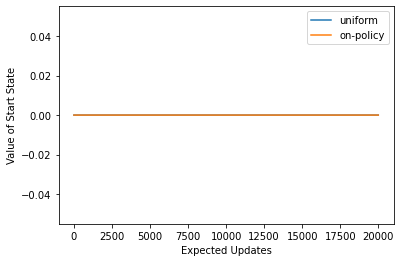

In [10]:
plot(uniform_reward, traject_reward, exp_updates)

### 4.1 Branching Factor 3

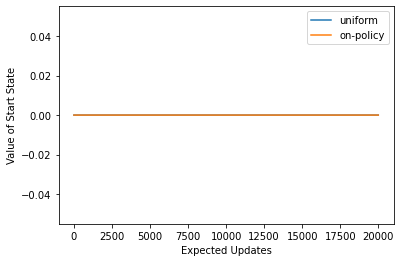

In [11]:
plot(uniform_reward2, traject_reward2, exp_updates)